In [177]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.datasets import fetch_california_housing, make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [7]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


In [8]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

In [9]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    result = f.eval()

In [10]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

42


In [11]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [12]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
    print(x2.graph is graph)
    print(x2.graph is tf.get_default_graph())
    
tf.reset_default_graph()

True
True


In [13]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

10
15


In [14]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
15


### Linear Regression: Normal Equation

In [15]:
housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

### Linear Regression: Gradient Descent

In [16]:
scaler = StandardScaler()
scaled_housing_data_plus_bias = scaler.fit_transform(housing_data_plus_bias)

In [17]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

tf.reset_default_graph()

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

with tf.name_scope("loss") as scope:
    error = tf.subtract(y_pred, y, name="subtr")
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
# gradients = 2/m * tf.matmul(tf.transpose(X), error)
gradients = tf.gradients(mse, [theta])[0]
# training_op = tf.assign(theta, theta - learning_rate * gradients)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
# saver = tf.train.Saver()
saver = tf.train.Saver({"weights": theta})

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
            save_path = saver.save(sess, "tmp/my_model.ckpt")
        
        if epoch % 10 == 0:
            summary_str = mse_summary.eval()
            file_writer.add_summary(summary_str, epoch)
            
        sess.run(training_op)
        
    best_theta = theta.eval()    
    save_path = saver.save(sess, "tmp/my_model_final.ckpt")
    
file_writer.close()

Epoch 0 MSE = 7.7685366
Epoch 100 MSE = 4.813532
Epoch 200 MSE = 4.8040013
Epoch 300 MSE = 4.8033423
Epoch 400 MSE = 4.8032656
Epoch 500 MSE = 4.803255
Epoch 600 MSE = 4.8032537
Epoch 700 MSE = 4.8032537
Epoch 800 MSE = 4.803254
Epoch 900 MSE = 4.8032537


In [18]:
print(error.op.name)
print(mse.op.name)

loss/subtr
loss/mse


### Restore graph and variables

In [19]:
tf.reset_default_graph()
saver = tf.train.import_meta_graph("tmp/my_model_final.ckpt.meta")

with tf.Session() as sess:
    saver.restore(sess, "tmp/my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from tmp/my_model_final.ckpt


### Mini-batch Gradient Descent

In [20]:
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5

with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A:[[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A:[[4, 5, 6], [7, 8, 9]]})
    
print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


In [26]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

with tf.name_scope("loss") as scope:
    error = tf.subtract(y_pred, y, name="subtr")
    mse = tf.reduce_mean(tf.square(error), name="mse")
    training_op = optimizer.minimize(mse)

n_epochs = 10

batch_size = 100
n_batches = int(np.ceil(m/batch_size))

init = tf.global_variables_initializer()

def fetch_batch(epoch, batch_index, batch_size):
    start = batch_index * batch_size
    end = (batch_index+1) * batch_size
    X_batch = scaled_housing_data_plus_bias[start:end]
    y_batch = housing.target.reshape(-1, 1)[start:end]
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
#         if epoch % 1 == 0:
#             print("Epoch", epoch, "MSE =", mse.eval())
            
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
    best_theta = theta.eval()

In [27]:
best_theta

array([[-1.8894577e-01],
       [-1.6921010e+07],
       [ 7.4770295e+06],
       [-1.4285365e+08],
       [-1.2047077e+07],
       [ 3.3885292e+07],
       [ 5.7883872e+08],
       [-3.4595604e+07],
       [-3.1231138e+06]], dtype=float32)

### Modularity

In [28]:
def relu(X):
    with tf.name_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="relu")

tf.reset_default_graph()

n_features = 3
# X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
X = tf.constant(np.random.randn(1, 3), dtype=tf.float32)

relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index>0)) as scope:
        relus.append(relu(X))
    
output = tf.add_n(relus, name="output")
summary_str = tf.summary.tensor_summary('output', output)

init = tf.global_variables_initializer()

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    
#     X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
#     file_writer.add_summary(summary_str.eval(feed_dict={X: X_batch[0:1, 0:3]}, session=sess))

    file_writer.add_summary(summary_str.eval(session=sess))
    
file_writer.close()  

In [29]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='relu')

[<tf.Variable 'relu/threshold:0' shape=() dtype=float32_ref>,
 <tf.Variable 'relu/relu/weights:0' shape=(3, 1) dtype=float32_ref>,
 <tf.Variable 'relu/relu/bias:0' shape=() dtype=float32_ref>,
 <tf.Variable 'relu_1/relu/weights:0' shape=(3, 1) dtype=float32_ref>,
 <tf.Variable 'relu_1/relu/bias:0' shape=() dtype=float32_ref>,
 <tf.Variable 'relu_2/relu/weights:0' shape=(3, 1) dtype=float32_ref>,
 <tf.Variable 'relu_2/relu/bias:0' shape=() dtype=float32_ref>,
 <tf.Variable 'relu_3/relu/weights:0' shape=(3, 1) dtype=float32_ref>,
 <tf.Variable 'relu_3/relu/bias:0' shape=() dtype=float32_ref>,
 <tf.Variable 'relu_4/relu/weights:0' shape=(3, 1) dtype=float32_ref>,
 <tf.Variable 'relu_4/relu/bias:0' shape=() dtype=float32_ref>]

### Exercises

In [318]:
def fetch_batch(epoch, batch_index, batch_size):
    seed = batch_size + epoch * batch_index
    inds = np.random.randint(0, m-1, batch_size)
    
    return X_full[inds], y_full_oh[inds]

# m, m x k arrays
def softmax(Theta, x):
    S_exp = tf.exp(tf.matmul(x, Theta))
    
    return tf.divide(S_exp, tf.reduce_sum(S_exp, 1, keepdims=True))
#     return S_exp

# scalar
def cross_entropy(y_true, p_pred, batch_size):
    cost_1 = tf.matmul(y_true, tf.log(p_pred), True)
    cost_2 = tf.matmul(1-y_true, tf.log(1-p_pred), True)
    return -(cost_1 + cost_2)/batch_size
#     return cost_1
    
#     return - tf.divide(tf.reduce_sum(y_log_h, axis=0), batch_size)
#      return -tf.reduce_mean(tf.matmul(y_true, tf.log(p_pred), True), 1)

# k x n arrays
def get_gradients(error, X):
    a = tf.matmul(X, error, True)
    
    return tf.divide(a, tf.to_float(tf.shape(X)[0]))

# m x k arrays
def y_to_prob(y):
    prob = np.zeros((len(y), max(y)+1))
    for m_, y_ in enumerate(y):
        prob[m_, y_] = 1
    return prob

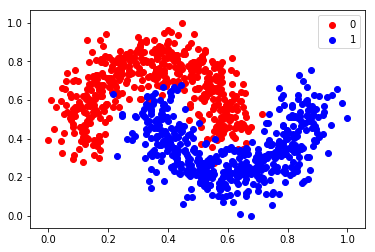

In [315]:
m = 1000
n = 2

X_full, y_full = make_moons(n_samples=m, noise = 0.2, random_state=42)

scaler = MinMaxScaler()
X_full = scaler.fit_transform(X_full)

X_full = np.c_[X_full, np.ones(shape=(m))]
y_full = y_full.reshape(-1, 1)
y_full_oh = y_to_prob(y_full[:, 0])

plt.scatter(X_full[y_full[:, 0]==0][:, 0], X_full[y_full[:, 0]==0][:, 1], c='r', label='0')
plt.scatter(X_full[y_full[:, 0]==1][:, 0], X_full[y_full[:, 0]==1][:, 1], c='b', label='1')
plt.legend(loc='best')
plt.show()

In [337]:
logdir

'tf_logs/run-20180902084117/'

In [341]:
tf.reset_default_graph()

learning_rate = 0.01
n_epochs = 100
batch_size = 50
n_batches = int(np.ceil(m/batch_size))

X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 2), name="y")
theta = tf.Variable(tf.random_uniform([n+1, 2], -1.0, 1.0), name="theta")
y_pred = softmax(theta, X)

# ce = cross_entropy(y, y_pred, batch_size)

ce = tf.losses.softmax_cross_entropy(y, y_pred)

error = tf.subtract(y_pred, y, "error")

# gradients = tf.gradients(tf.subtract(y, y_pred), [theta])[0]
gradients = get_gradients(error, X)
theta_new = tf.subtract(theta, tf.scalar_mul(learning_rate, gradients))
training_op = tf.assign(theta, theta_new)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
# training_op = optimizer.minimize(error)

init = tf.global_variables_initializer()

ce_summary = tf.summary.scalar('cross-entropy', ce)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(batch_size):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
#             y_pred_ = y_pred.eval(feed_dict={X: X_batch})
#             error_ce = ce.eval(feed_dict={X: X_batch, y: y_batch})
            if batch_index==batch_size-1:
                summary_str = ce_summary.eval(feed_dict={X: X_batch, y: y_batch}) 
                file_writer.add_summary(summary_str, epoch)
#             training_op.eval(feed_dict={X: X_batch, y: y_batch})
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
#             error_ = error.eval(feed_dict={X: X_batch, y: y_batch})
#             print(error_)

    file_writer.close()    
        
#     print(sess.run(
#         tf.slice(tf.matmul(tf.cast(X_full, tf.float32), theta), [0, 0], [10, 2])))
    print(sess.run(y_pred, feed_dict={X: X_full[:10]}))

[[0.7174785  0.2825215 ]
 [0.18003349 0.81996655]
 [0.3403143  0.65968573]
 [0.22066681 0.77933323]
 [0.80616844 0.19383156]
 [0.32807818 0.67192185]
 [0.3379721  0.6620279 ]
 [0.7240183  0.27598175]
 [0.14485788 0.8551421 ]
 [0.7723649  0.22763506]]
